In [1]:
#auto tsp libraries
from numpy import *
from qiskit import *
from math import *
from numpy import *
import networkx as nx
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.circuit.library import QFT
from random import randint
###################################
#parsl libraries
import parsl
import os
from parsl.app.app import python_app, bash_app
from parsl.configs.local_threads import config
parsl.load(config)

In [2]:
def controlled_unitary(qc, qubits: list, phases: list): # x,y,z = Specific Qubit; a,b,c,d = Phases
    qc.cp(phases[2]-phases[0], qubits[0], qubits[1]) # controlled-U1(c-a)
    qc.p(phases[0], qubits[0]) # U1(a)
    qc.cp(phases[1]-phases[0], qubits[0], qubits[2]) # controlled-U1(b-a)
    
    # controlled controlled U1(d-c+a-b)
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp(-(phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[0], qubits[2])

def U(times, qc, unit, eigen, phases: list): # a,b,c = phases for U1; d,e,f = phases for U2; g,h,i = phases for U3; j,k,l = phases for U4; m_list=[m, n, o, p, q, r, s, t, u, a, b, c, d, e, f, g, h, i, j, k, l]
    controlled_unitary(qc, [unit[0]]+eigen[0:2], [0]+phases[0:3])
    controlled_unitary(qc, [unit[0]]+eigen[2:4], [phases[3]]+[0]+phases[4:6])
    controlled_unitary(qc, [unit[0]]+eigen[4:6], phases[6:8]+[0]+[phases[8]])
    controlled_unitary(qc, [unit[0]]+eigen[6:8], phases[9:12]+[0])
    
def final_U(times, eigen, phases: list):
    unit = QuantumRegister(1, 'unit')
    qc = QuantumCircuit(unit, eigen)
    for _ in range(2**times):
        U(times, qc, unit, eigen, phases)
    return qc.to_gate(label='U'+'_'+(str(2**times)))

# Storing the eigenvalues in a list
eigen_values = ["11000110", "10001101", "01001011"]
#index 0 is 1-2-3-4-1
#index 1 is 1-4-2-3-1
#index 2 is 1-3-4-2-1

def which_eigen(index):
    if index == 0:
        return "1-2-3-4-1"
    elif index == 1:
        return "1-4-2-3-1"
    else:
        return "1-3-4-2-1"

# Function to place appropriate corresponding gate according to eigenstates
def eigenstates(qc, eigen_list, index):
    for i in range(0, len(eigen_list)):
        if eigen_values[index][i] == '1':
            qc.x(eigen_list[i])
        if eigen_values[index][i] == '0':
            pass
    print("Chosen Eigen value is:", eigen_values[index], "which is", which_eigen(index))
    return qc

In [3]:
#Positions are generated and then it does the networkx map
@python_app
def generate_positions():
    #Positions are generated and then it does the networkx map
    global ax, ay, bx, by, cx, cy, dx, dy
    ax = randint(1,1000)
    ay = randint(1,1000)
    bx = randint(1,1000)
    by = randint(1,1000)
    cx = randint(1,1000)
    cy = randint(1,1000)
    dx = randint(1,1000)
    dy = randint(1,1000)
    print("test")

@python_app
def networkx_map():
    #Plotting the random TSP from above, for reference
    F = nx.DiGraph(directed=True)
    F.add_edge(1, 2)
    F.add_edge(1, 3)
    F.add_edge(1, 4)
    F.add_edge(2, 1)
    F.add_edge(2, 3)
    F.add_edge(2, 4)
    F.add_edge(3, 1)
    F.add_edge(3, 2)
    F.add_edge(3, 4)
    F.add_edge(4, 1)
    F.add_edge(4, 2)
    F.add_edge(4, 3)
    pos = {1: [ax, ay],
          2: [bx, by],
          3: [cx, cy],
          4: [dx, dy]}
    edge_labels = {(1, 2): '$\\phi_{2\\to 1}$\n $\\phi_{1\\to 2}$',
                  (1, 3): '$\\phi_{1\\to 3}$\n $\\phi_{3\\to 1}$',
                  (1, 4): '$\\phi_{4\\to 1}$\n $\\phi_{1\\to 4}$',
                  (2, 3): '$\\phi_{2\\to 3}$\n $\\phi_{3\\to 2}$',
                  (2, 4): '$\\phi_{4\\to 2}$\n $\\phi_{2\\to 4}$',
                  (3, 4): '$\\phi_{4\\to 3}$\n $\\phi_{3\\to 4}$'
                  }
    fig = plt.figure(1, figsize=(12, 5)) 
    nx.draw(F, with_labels=True, node_color='green', pos=pos, node_size=3000, arrowsize=12, arrowstyle='simple', font_size=30, font_color = 'white')
    nx.draw_networkx_edge_labels(F, pos, edge_labels=edge_labels, font_size=20, bbox=dict(alpha=0))
    #plt.show()
    plt.savefig("Graph.png", format="PNG")

In [4]:
@python_app
def generate_distances():
    #Distances calculated
    global two_one, three_one, four_one, one_two, three_two, four_two, one_three, two_three, four_three, one_four, two_four, three_four
    two_one = sqrt(((bx-ax)**2)+((by-ay)**2))
    three_one = sqrt(((cx-ax)**2)+((cy-ay)**2))
    four_one = sqrt(((dx-ax)**2)+((dy-ay)**2))
    one_two = sqrt(((ax-bx)**2)+((ay-by)**2))
    three_two = sqrt(((cx-bx)**2)+((cy-by)**2))
    four_two = sqrt(((dx-bx)**2)+((dy-by)**2))
    one_three = sqrt(((ax-cx)**2)+((ay-cy)**2))
    two_three = sqrt(((bx-cx)**2)+((by-cy)**2))
    four_three = sqrt(((dx-cx)**2)+((dy-cy)**2))
    one_four = sqrt(((ax-dx)**2)+((ay-dy)**2))
    two_four = sqrt(((bx-dx)**2)+((by-dy)**2))
    three_four = sqrt(((cx-dx)**2)+((cy-dy)**2))
    #Putting them all in a list to find the least value
    global ph_list
    ph_list = [two_one, three_one, four_one, one_two, three_two, four_two, one_three, two_three, four_three, one_four, two_four, three_four]
    global smallest_distance
    smallest_distance = min(ph_list)

@python_app
def phase_conversion():
    #Initializing the values for the array
    x = (smallest_distance*pi)/2
    print(x)
    global phases
    phases = [(1/ph_list[0])*x, (1/ph_list[1])*x, (1/ph_list[2])*x, (1/ph_list[3])*x, (1/ph_list[4])*x, (1/ph_list[5])*x, (1/ph_list[6])*x, (1/ph_list[7])*x, (1/ph_list[8])*x, (1/ph_list[9])*x, (1/ph_list[10])*x, (1/ph_list[11])*x]

In [5]:
@python_app
def quantum_circuit():
    ##############INDEX 0##########################
    global qc, qc1, qc2
    # Creating the 14 qubit circuit, 6 are for the qft and the rest are for the eigenvectors/QPE
    unit = QuantumRegister(6, 'unit')
    eigen = QuantumRegister(8, 'eigen')
    unit_classical = ClassicalRegister(6, 'unit_classical')
    qc = QuantumCircuit(unit, eigen, unit_classical)
    # Setting one eigenstate, puts not gates into circuit  
    eigenstates(qc, eigen, 0)
    #

    # Hadamard on the 'unit' qubits
    qc.h(unit[:])
    #

    # Controlled Unitary  
    for i in range(0, 6):
        qc.append(final_U(i, eigen, phases), [unit[5-i]] + eigen[:])
    #

    # Inverse QFT 
    qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=False, do_swaps=False, name='QFT^-1')
    qc.append(qft, qc.qubits[:len(unit)])
    #

    # Measure
    qc.measure(unit, unit_classical)
    #
    #
    ##############INDEX 1##########################
    # Creating the 14 qubit circuit, 6 are for the qft and the rest are for the eigenvectors/QPE
    unit = QuantumRegister(6, 'unit')
    eigen = QuantumRegister(8, 'eigen')
    unit_classical = ClassicalRegister(6, 'unit_classical')
    qc1 = QuantumCircuit(unit, eigen, unit_classical)
    #

    # Setting one eigenstate, puts not gates into circuit  
    eigenstates(qc1, eigen, 1)
    #

    # Hadamard on the 'unit' qubits
    qc1.h(unit[:])
    #

    # Controlled Unitary  
    for i in range(0, 6):
        qc1.append(final_U(i, eigen, phases), [unit[5-i]] + eigen[:])
    #

    # Inverse QFT 
    qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=False, do_swaps=False, name='QFT^-1')
    qc1.append(qft, qc1.qubits[:len(unit)])
    #

    # Measure
    qc1.measure(unit, unit_classical)
    #
    #
    ##############INDEX 2##########################
    # Creating the 14 qubit circuit, 6 are for the qft and the rest are for the eigenvectors/QPE
    unit = QuantumRegister(6, 'unit')
    eigen = QuantumRegister(8, 'eigen')
    unit_classical = ClassicalRegister(6, 'unit_classical')
    qc2 = QuantumCircuit(unit, eigen, unit_classical)
    #

    # Setting one eigenstate, puts not gates into circuit  
    eigenstates(qc2, eigen, 2)
    #

    # Hadamard on the 'unit' qubits
    qc2.h(unit[:])
    #

    # Controlled Unitary  
    for i in range(0, 6):
        qc2.append(final_U(i, eigen, phases), [unit[5-i]] + eigen[:])
    #

    # Inverse QFT 
    qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=False, do_swaps=False, name='QFT^-1')
    qc2.append(qft, qc2.qubits[:len(unit)])
    #

    # Measure
    qc2.measure(unit, unit_classical)
    #
    

In [6]:
@python_app
def qasm_sim():
    #Running all three at once on the local simulator and finding the results 
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1000)
    job1 = execute(qc1, backend, shots=1000)
    job2 = execute(qc2, backend, shots=1000)
    count = job.result().get_counts()
    count1 = job1.result().get_counts()
    count2 = job2.result().get_counts()
    counts_list = [count.most_frequent(), count1.most_frequent(), count2.most_frequent()]
    print("The most frequent output for", eigen_values[0], "aka", which_eigen(0), "\b, is", counts_list[0])
    print("The most frequent output for", eigen_values[1], "aka", which_eigen(1), "\b, is", counts_list[1])
    print("The most frequent output for", eigen_values[2], "aka", which_eigen(2), "\b, is", counts_list[2])
    #
    int_counts_list =[]
    for i in range(3):
        int_counts_list.append(int(counts_list[i], 2))
    print(int_counts_list)
    maximum = max(int_counts_list)
    maximum_indices = []
    for i in range(3):
        if int_counts_list[i] == maximum:
            maximum_indices.append(which_eigen(i))
    print("The maximum returned value, which is equivalent to the shortest distance, is", maximum, "and the corresponding path is:", maximum_indices)
    #calculate the miles 
    print()
    print("The actual distances are:")
    print("1-2-3-4-1 = ", two_one + three_two + four_three+one_four ,"km")
    print("1-4-2-3-1 = ", one_four + two_four + three_two +one_three ,"km")
    print("1-3-2-4-1 = ", three_one + four_three + two_four + one_four,"km")

In [7]:
@python_app
def quantum_computer():
    #ALERT, DO NOT RUN THIS CODE BLOCK UNLESS ABSOLUTELY NECESSARY
    #running the code on a real quantum computer
    qc_list = [qc, qc1, qc2]
    #On ibmq kolkata
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='csc494')
    provider.backends()
    backend = provider.get_backend('ibmq_kolkata')
    job = execute(qc_list, backend)
    print(job.job_id())
    job = backend.retrieve_job(job.job_id()) 
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    plot_histogram(job.result().get_counts(), filename = histogram.pdf)
    

test
329.380670924957
Chosen Eigen value is: 11000110 which is 1-2-3-4-1
Chosen Eigen value is: 10001101 which is 1-4-2-3-1
Chosen Eigen value is: 01001011 which is 1-3-4-2-1
The most frequent output for 11000110 aka 1-2-3-4-1, is 010110
The most frequent output for 10001101 aka 1-4-2-3-1, is 011110
The most frequent output for 01001011 aka 1-3-4-2-1, is 000111
[22, 30, 7]
The maximum returned value, which is equivalent to the shortest distance, is 30 and the corresponding path is: ['1-4-2-3-1']

The actual distances are:
1-2-3-4-1 =  2761.9497774924985 km
1-4-2-3-1 =  2354.7089287604767 km
1-3-2-4-1 =  2552.589307313561 km


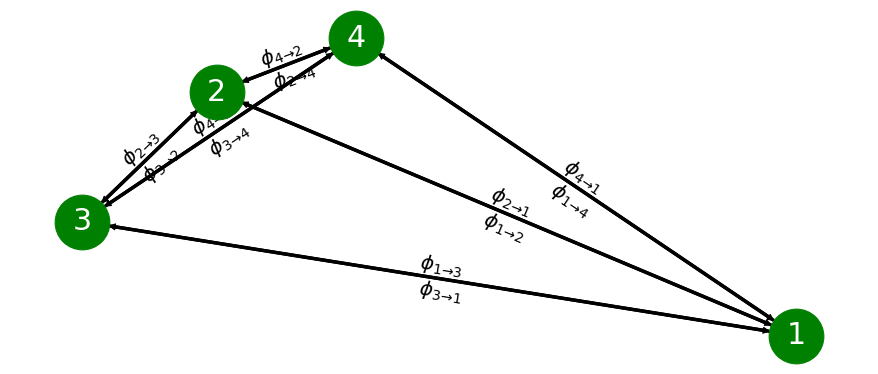

In [8]:
#running the actual code
generate_positions().result()
#next two can run at the same time
networkx_map().result()
generate_distances().result()
#
phase_conversion().result()
quantum_circuit().result()
#these next two can run at the same time
qasm_sim().result()

In [ ]:
quantum_computer().result()